In [1]:
include("src/SpinonStructure.jl")
include("src/BZMath.jl")
# include("PyrochloreGeometry.jl")
# import .PyrochloreGeometry as geom
using .BZmath
using .SpinonStructure
using LinearAlgebra
using StaticArrays
using BenchmarkTools
using Plots

In [2]:
import RandomMatrices

In [2]:
using Rotations
using LinearAlgebra

function M_analytic_0flux(Jpm, k)
    n = [1,0,0]
    n ./= norm(n)
    
    # R = AngleAxis(π/8, n...)
    R = AngleAxis(0, n...)
    e = Jpm/2*( cos( k'*R*[0,4,4]) + cos( k'*R*[4,0,4]) + cos( k'*R*[4,4,0]) + cos( k'*R*[0,4,-4]) + cos( k'*R*[4,0,-4]) + cos( k'*R*[4,-4,0]) )
    
    return e
end



function M_analytic_0flux_doubled(Jpm, k)
    n = [1,0,0]
    n ./= norm(n)
    
    # R = AngleAxis(π/8, n...)
    R = AngleAxis(0, n...)
    e = Jpm/2*( cos( k'*R*[0,4,4]) + cos( k'*R*[4,0,4]) + cos( k'*R*[4,4,0]) + cos( k'*R*[0,4,-4]) + cos( k'*R*[4,0,-4]) + cos( k'*R*[4,-4,0]) )
    u = rand(RandomMatrices.Haar(2),2)
    return adjoint(u)*diagm([e,e])*u
end


M_analytic_0flux_doubled (generic function with 1 method)

In [4]:
lat_test = geom.PyroFCC(50)

@benchmark geom.tetra_idx(lat_test, lat_test.tetra_sites[1+abs(rand(Int64)) % length(lat_test.tetra_sites)] )


BenchmarkTools.Trial: 10000 samples with 685 evaluations.
 Range (min … max):  182.847 ns …   6.700 μs  ┊ GC (min … max): 0.00% … 95.76%
 Time  (median):     193.127 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   202.438 ns ± 119.680 ns  ┊ GC (mean ± σ):  2.35% ±  4.01%

     ▄█▇▆▃▁▂                                                     
  ▂▃▇████████▇▇▆▆▄▅▄▄▄▄▄▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  183 ns           Histogram: frequency by time          249 ns <

 Memory estimate: 191 bytes, allocs estimate: 6.

In [95]:
8 >> 3

1

In [100]:
for mu=1:4
    tmp = geom.fcc_Dy[mu] + geom.diamond[1] + 8 .*[4, -9, -11]
    # tmp = tetra_pos .& 0x4
    println(1 + ( (tmp[2]&0x4) >> 2 | (tmp[1]&0x4 )>> 1  ))
end

1
2
3
4


In [5]:
lat_test = geom.PyroFCC(2)

for l in lat_test.tetra_sites
    # tmp = MVector{3}(l)
    idx = tetra_idx_fast(lat_test, l)
    # println(l .>>2)
    if l != lat_test.tetra_sites[idx]
        println(l, "  ", lat_test.tetra_sites[idx])
    end
end

LoadError: UndefVarError: `tetra_idx_fast` not defined

In [4]:

function calc_M(K)
    A = rand(4,4)
    B = @SVector Float64[0,0,0]
    lat = SpinonStructure.geom.PyroFCC(1)
    return SpinonStructure.calc_xxz_hopping_fast(lat, K, A) + SpinonStructure.calc_nn_hopping(lat, K, A, B)
end

calc_M (generic function with 1 method)

In [5]:
swap = zeros(8,8)
swap[1:4,5:8] = diagm(ones(4))
swap += swap'

k = @SVector Float64[1,2,3]


swap*calc_M(k ) - conj(calc_M(-k ))*swap

8×8 Matrix{ComplexF64}:
       0.0+0.0im               0.0+0.0im       …  -0.0713149+0.0178613im
       0.0+0.0im               0.0+0.0im          -0.0728501+0.507267im
       0.0+0.0im               0.0+0.0im            0.224041+0.275335im
       0.0+0.0im               0.0+0.0im                 0.0+0.0im
       0.0+0.0im          0.455129-0.157712im            0.0+0.0im
  0.455129+0.157712im          0.0+0.0im       …         0.0+0.0im
 0.0614293-0.0107726im  -0.0683453-0.280765im            0.0+0.0im
 -0.302112-0.107346im     0.122418-0.162963im            0.0+0.0im

In [8]:
high_symmetry_points = Dict(
    "\\Gamma"=> [0.,0.,0.],
    "X"=> [1.,0.,0.],
    "W"=> [1.,0.5,0.],
    "K"=> [0.75,0.75,0.],
    "L"=> [0.5,0.5,0.5],
    "U"=> [1.0, 0.25,0.25]
)

high_symmetry_points_2 = Dict(
    "\\Gamma"=> [0.,0.,0.],
    "X"=> [1.,0.,0.],
    "W"=> [1.,0.5,0.],
    "K"=> [0.75,0.75,0.],
    "L"=> [0.5,0.5,0.5],
    "U"=> [1.0, 0.25,0.25]
)

path = generate_path(high_symmetry_points, split("\\Gamma X W K \\Gamma L U W"), points_per_unit=30, K_units=4π/8);

In [7]:
sim_0 = SpinonStructure.SimulationParameters("0flux", A=zeros(4,4), Jpm=-0.046, B=zeros(3), nsample=10000, kappa=2.0)
sim_0.λ

0.14109278723205357

In [8]:
# function diagm(M):
#     return eigvals!(M)
# end

lambda_g = SpinonStructure.calc_lambda( k-> M_analytic_0flux(sim_0.Jpm, k),10000,2.)
    

0.14153663374116335

In [25]:
SpinonStructure.calc_lambda( k-> eigvals!(Hermitian(M_analytic_0flux_doubled(sim_0.Jpm, k))),10000,2.)

0.1419819336210794

In [6]:
using Printf

f1 = k-> spinon_dispersion(k, sim_0 )[1]


function plot_spinons(f;color=:black)
    E = reduce(vcat, map(f, path.K )')

    plot!(path.t,E,legend=false,color=color,lw=0.5)
    xticks!(path.ticks_t, path.ticks_label)
    ylims!(0.,maximum(E))

    # bstr = @sprintf("[%.3f,%.3f,%.3f]",sim.B[1],sim.B[2],sim.B[3])  
    # if norm( abs.(sim.B/norm(sim.B))- [1,1,1]/√3) < 1e-8
    #     bstr = @sprintf("%.3f [1,1,1]/\\sqrt{3}", norm(sim.B) )
    # elseif norm( abs.(sim.B/norm(sim.B))- [1,1,0]/√2) < 1e-8
    #     bstr = @sprintf("%.3f [1,1,0]/\\sqrt{2}", norm(sim.B))
    # end
    # title!(@sprintf("\$J_\\pm=%.3fJ_{yy}, B=%s J_{yy}\$",sim.Jpm,bstr)  )
    # savefig(@sprintf("figures/dispersion_%s?J_pm=%.3f?B=[%.3f,%.3f,%.3f].pdf",sim.name,sim.Jpm,sim.B[1],sim.B[2],sim.B[3])  )
    
    return plot!()
end

plot_spinons (generic function with 1 method)

In [9]:
plot()

plot_spinons(f1,color=:red)
# plot_spinons( k-> sqrt(2)*sqrt(M_analytic_0flux(sim_0.Jpm, k) + lambda_g)  )
# plot_spinons( k-> sqrt(2)*sqrt(M_analytic_0flux(sim_0.Jpm, k+[2π/8,0,0]) + lambda_g)  )
# plot_spinons( k-> sqrt(2)*sqrt(M_analytic_0flux(sim_0.Jpm, k+[0,2π/8,0]) + lambda_g)  )
# plot_spinons( k-> sqrt(2)*sqrt(M_analytic_0flux(sim_0.Jpm, k+[0,0,2π/8]) + lambda_g)  )

LoadError: UndefVarError: `sim_0` not defined

In [32]:
function spinon_dispersion_analytic(k, sim)
    ϵ = M_analytic_0flux(sim.Jpm, k)
    return sqrt( 2 .*(ϵ + sim.λ))
end

function spinon_dispersion_analytic_doubled(k, sim)
    M = M_analytic_0flux_doubled(sim.Jpm, k)
    ϵ, U = eigvals!(Hermitian(M))
    return sqrt( 2 .*(ϵ + sim.λ)), U
end

spinon_dispersion_analytic_doubled (generic function with 1 method)

In [12]:
# define static convenience types

const Vec3 = geom.Vec3;
const Vec3_F64 = geom.Vec3_F64;
################################################################################
### Calculating the spectral weight
################################################################################

"""
	specweight_at(q, Δ, sim)
	-> E, S

Calculates the contribution of kspace points(q ± Δ) to the Δ integral in 
`spectral_weight`. Let there be N tetrahedra in `sim`, i.e. N bands.
Returns: 
`E`, an (N, N) matrix of e1 + e2 energies corresponding to Dirac delta peaks
`S`, an (N, N) matrix of spectral weights giving the heights of these peaks
"""
function specweight_at(q::Vec3_F64, k::Vec3_F64, sim::SimulationParameters)
    E1 = spinon_dispersion_analytic( k, sim)
    E2 = spinon_dispersion_analytic( q-k, sim)
    
    S = 0
    for mu=1:4, nu=1:4
        S += 1/(E1*E2)*exp(-2im*(q/2-k)'*(geom.pyro[mu]-geom.pyro[nu]))
    end
    E = E1 + E2
    return E, S
end

specweight_at

In [44]:
function tetra_idx_safe(lattice::geom.PyroFCC, tetra_pos::Vec3)
    idx = geom.tetra_idx(lattice, tetra_pos)
     
    if lattice.tetra_sites[idx] != tetra_pos
        return nothing
    end
    return idx
end
    

function specweight_at_doubled(q::Vec3_F64, p::Vec3_F64, sim::SimulationParameters)
    S = 0
    
    E1, U1 = spinon_dispersion_analytic_doubled( p, sim )
    E2, U2 = spinon_dispersion_analytic_doubled( q-p, sim )

    W = zeros(ComplexF64,4,4)
    
    for μ=1:4, ν=1:4
        W[μ,ν] = exp(2im*(q/2 - p)'* (geom.pyro[μ]-geom.pyro[ν]))
    end
    

    local f=length(sim.lat.tetra_sites)
    S = zeros(f,f)

    A_sites = [ (@SVector [0,0,0]) ]
    
    for μ=1:4, ν=1:4
        for (jA, rA) in enumerate(A_sites), (jpA, rpA) in enumerate(A_sites)
            jB = tetra_idx_safe(sim.lat, rA + 2*geom.pyro[μ])
            jpB = tetra_idx_safe(sim.lat, rpA + 2*geom.pyro[ν])

            # the "l" bit
            x1 = U1[jA, :] .* conj(U1[jpA, :]) ./ (2*E1) 
            # the "l'" bit
            x2 = U2[jpB, :] .* conj(U2[jB, :]) ./ (2*E2) # <--- calculation says this one
            # x2 = U2[jB, :] .* conj(U2[jpB, :]) ./ (2*E2) # makes no difference 
            
            
            S += W[μ,ν]*exp(1im*(sim.A[jA,μ]-sim.A[jpA, ν])) * x2*x1'
        end
    end
    E = [e1 + e2 for e2 in E2, e1 in E1]::Matrix{Float64}
    return E, S
end


specweight_at_doubled (generic function with 1 method)

In [45]:


"""
    spectral_weight(q, Egrid, sim::SimulationParameters, 
						 nsample::Int=1000, grid_density::Int=1000
						 )

Calculates the spectral weight at point `q`.

This performs a Monte Carlo integral over the Brillouin zone.
`grid_density` sets the number of points in one dimension of the Brillouin zone.
`nsample` is the number of these k-points to sample.

"""
function spectral_weight(q::Vec3_F64, Egrid::Vector{Float64}, sim::SimulationParameters, 
						 integral_params::IntegrationParameters
						 )
    # cursed Monte Carlo integration
    num_flavours = div(length(sim.A),2)

    grid_density=integral_params.BZ_grid_density

    Sqω = zeros(ComplexF64,size(Egrid))

    bounds = [Inf, -Inf]
    
    for _ in 1:integral_params.n_K_samples
        k =  (1 .- 2 .*(@SVector rand(3)))*8π/8
        E, s = specweight_at(q, k, sim)
        
        Sqω += s*map(
            e-> Lorentzian(e - E, integral_params.broadening_dE),
                Egrid) 
        bounds[1] = min(bounds[1], E ) 
        bounds[2] = max(bounds[2], E )
    end
    return Sqω, bounds
end

spectral_weight

In [46]:
function spectral_weight_doubled(q::Vec3_F64, Egrid::Vector{Float64}, sim::SimulationParameters, 
						 integral_params::IntegrationParameters
						 )
    # cursed Monte Carlo integration
    grid_density=integral_params.BZ_grid_density

    Sqω = zeros(ComplexF64,size(Egrid))
    # perform an MC integral
    # dE = (Egrid[2]-Egrid[1])*broaden_factor

    bounds = [Inf, -Inf]
    
    for _ = 1:integral_params.n_K_samples
        
        p = (1 .- 2 .*(@SVector rand(3)))*8π/8
        
        Enm, Snm = specweight_at_doubled(q, p, sim)
        Sqω += map(
            e-> sum( [S*Lorentzian(e - E, integral_params.broadening_dE) for (E,S) in zip(Enm,Snm)]),
                Egrid)
        bounds[1] = min(bounds[1], reduce(min,  Enm) ) 
        bounds[2] = max(bounds[2], reduce(max,  Enm) )
    end
    return Sqω, bounds
end

spectral_weight_doubled (generic function with 1 method)

In [47]:
@inline function Lorentzian(x, Γ)
    local N = 1/π
    Γ /= 2
    return N*1. * Γ/(x^2 + Γ^2)
end

Lorentzian (generic function with 1 method)

In [16]:
ip_GL = IntegrationParameters(n_K_samples=8,BZ_grid_density=50,broadening_dE=0.2)

ip_fast = IntegrationParameters(n_K_samples=100,BZ_grid_density=50,broadening_dE=0.05)
ip_slow = IntegrationParameters(n_K_samples=1000,BZ_grid_density=500,broadening_dE=0.05)
ip_very_slow = IntegrationParameters(n_K_samples=10000,BZ_grid_density=500,broadening_dE=0.02)
ip_ultra_slow = IntegrationParameters(n_K_samples=100000,BZ_grid_density=500,broadening_dE=0.005)

IntegrationParameters(100000, 500, 0.005)

In [48]:
using ProgressMeter

sim = sim_0
ip = ip_slow

Egrid = collect(range(0,1.3,100))
num_K = length(path.K)

bounds = zeros(Float64, num_K, 2)

p = Progress(num_K)

S = zeros(ComplexF64, num_K, length(Egrid))
for I = 1:num_K
    k = path.K[I]*0.5
    q = SVector(k[1], k[2], k[3])
    s, b = spectral_weight_doubled(q, Egrid, sim, ip)
    S[I, :] = s
    bounds[I,:] = b
    # S[I, :], bounds[I,:] = spectral_density_of_states_GL(q, Egrid, sim, ip)
    next!(p)
end

finish!(p)


LoadError: MethodError: no method matching getindex(::Float64, ::Int64, ::Colon)

[0mClosest candidates are:
[0m  getindex(::Number, ::Integer)
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:96[24m[39m
[0m  getindex(::Number, [91m::Integer...[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:101[24m[39m
[0m  getindex(::Number)
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:95[24m[39m
[0m  ...


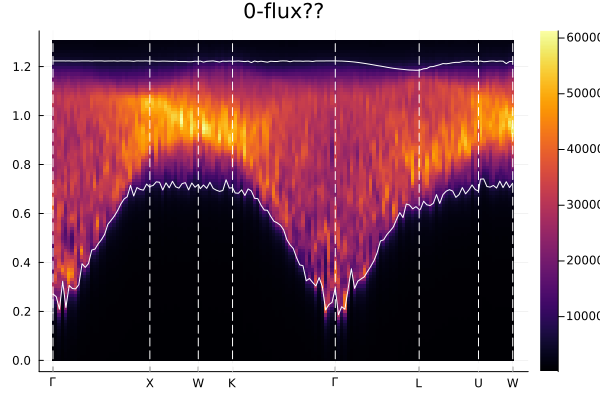

In [20]:
heatmap(path.t, Egrid, real(S)')#,clims=(10000,100000))
plot!(path.t, bounds,linecolor=:white)
plot!(legend=nothing)
vline!(path.ticks_t, linecolor=:white, linestyle=:dash)
xticks!(path.ticks_t, path.ticks_label)
title!("0-flux??")
plot!()
# hline!([
#         spinon_dispersion_analytic([0,0,0],sim)*2
#         spinon_dispersion_analytic([0,0,0],sim)+spinon_dispersion_analytic([2π/8,0,0],sim)
#         ])



2-element Vector{Float64}:
 0.6971155914968423
 1.223757039206928

In [46]:
spinon_dispersion_analytic([0,0,0],sim)+spinon_dispersion_analytic([2π/8,0,0],sim)

0.6918834238406929

In [77]:
geom.pyro

4-element Vector{SVector{3, Int64}}:
 [1, 1, 1]
 [1, -1, -1]
 [-1, 1, -1]
 [-1, -1, 1]

In [78]:
spinon_dispersion_analytic([0,0,0],sim)

0.0800009570767006

In [81]:
spinon_dispersion_analytic([2π/8,0,0],sim)

0.6118824667639923